In [1]:
# 示例代码运行环境
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 2.7.6
IPython 5.2.2

tensorflow 1.0.0
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [2]:
import tensorflow as tf
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import jieba
from jieba import posseg as pseg
from collections import Counter, defaultdict
import random
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import time
import math

In [4]:
def load_file(file_name):
    with open(file_name, 'rb') as f:
        segs = []
        sentences = []       
        lines = f.readlines()
        for line in lines:
            line = line.strip().decode('utf-8')
            words = pseg.cut(line)
            sentence = []
            for word, flag in words:            
                if flag == 'x':
                    if len(sentence) > 0:
                        sentences.append(sentence)
                        sentence = []
                else:
                    segs.append(word)
                    sentence.append(word)    
        return segs, sentences          

In [5]:
RAW_FILE = 'LuXun.txt'

In [6]:
t0 = time.time()

input_segs, input_sentences = load_file(RAW_FILE)

t1 = time.time()
print(t1-t0)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.296 seconds.
Prefix dict has been built succesfully.


20.211204052


In [7]:
print(len(input_segs))
print(len(input_sentences))

109983
25459


In [14]:
VOCAB_SIZE = 2000
UNK_WORD = 'UNK'
PADDING_WORD = '<PAD>'

In [15]:
def build_dataset(segs, sentences, vocab_size):    
    word_cnt = Counter(segs).most_common(vocab_size - 2)    
    word_dict = dict()  
    word_dict[PADDING_WORD] = 0 
    for word, _ in word_cnt:
        word_dict[word] = len(word_dict)    
    word_dict[UNK_WORD] = len(word_dict) 
    sentence_data = []
    unk_count = 0
    for sentence in sentences:
        cur_sentence = []
        for word in sentence:
            if word in word_dict:
                index = word_dict[word]
            else:
                index = word_dict[UNK_WORD]  # UNK_WORD
                unk_count += 1
            cur_sentence.append(index)
        sentence_data.append(cur_sentence)    
    reverse_dict = dict(zip(word_dict.values(), word_dict.keys())) 
    return sentence_data, word_cnt, word_dict, reverse_dict
    

In [16]:
input_data, word_count, word_dict, reverse_dict = build_dataset(input_segs, input_sentences, VOCAB_SIZE)

In [17]:
print(len(input_data))
print(len(word_count))
print(len(word_dict))

print input_data[:10]
print word_dict[UNK_WORD]
print word_dict[PADDING_WORD]
print reverse_dict[0]
print reverse_dict[1999]

25459
1998
2000
[[754, 55, 181, 914, 907, 104, 263, 1140, 1999, 1, 1999], [1999, 1999], [194, 1999, 1999, 260], [150, 1999, 1999, 1999], [483, 95], [1999], [55, 184, 1061, 938, 302, 108], [1273], [1833, 30], [1391, 1738]]
1999
0
<PAD>
UNK


In [18]:
PADDING = 0

#把每个mini batch的句子按当前batch中最长的句子长度做padding
def padding_data(data, max_length):
    for s in data:
        if (len(s)) < max_length:
            padding = [PADDING] * (max_length-len(s))
            s.extend(padding)
    return data

In [19]:
def generate_batch_data(size, index, raw_data):
    batch = raw_data[index:index+size]
    data_len = []
    for i in range(len(batch)):
        data_len.append(len(batch[i]))
    max_len = data_len[np.argmax(data_len)]
    batch_padding = padding_data(batch, max_len)
    batch_padding = np.asarray(batch_padding)
    batch_data = batch_padding[:, :-1]
    batch_labels = batch_padding[:, 1:]
    batch_mask = np.sign(batch_labels)
    sequence_len = []
    for m in batch_mask:
        sequence_len.append(np.sum(m)+1)
    return batch_data, batch_labels, batch_mask, sequence_len 

In [59]:
batch_size = 125

In [60]:
train_data, train_label, m, s = generate_batch_data(3, 0, input_data)

print input_data[:3]
print train_data
print train_label
print m
print s

[[754, 55, 181, 914, 907, 104, 263, 1140, 1999, 1, 1999, 0, 0, 0, 0], [1999, 1999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [194, 1999, 1999, 260, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[ 754   55  181  914  907  104  263 1140 1999    1 1999    0    0    0]
 [1999 1999    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 194 1999 1999  260    0    0    0    0    0    0    0    0    0    0]]
[[  55  181  914  907  104  263 1140 1999    1 1999    0    0    0    0]
 [1999    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [1999 1999  260    0    0    0    0    0    0    0    0    0    0    0]]
[[1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0]]
[11, 2, 4]


In [67]:
tf.reset_default_graph()

In [68]:
    vocab_size = VOCAB_SIZE
    word_embedding_dim = 30
    train_dataset = tf.placeholder(tf.int32, shape=[None, None], name='data')
    train_labels = tf.placeholder(tf.int32, shape=[None, None], name='label')
    labels_flat = tf.reshape(train_labels, (-1,))
    
    cell = tf.contrib.rnn.BasicRNNCell(word_embedding_dim)
    word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
    input_embeds = tf.nn.embedding_lookup(word_embedding, train_dataset)
    output, states = tf.nn.dynamic_rnn(cell, input_embeds, dtype=tf.float32)
    output_flat = tf.reshape(output, (-1, word_embedding_dim))
    
    seq_len = tf.placeholder(tf.int32, shape=[None])
    mask = tf.cast(tf.sign(labels_flat), tf.float32)
    
    seq_len = tf.reduce_sum(tf.sign(train_dataset), axis=1)  
    max_seq_len = tf.reduce_max(seq_len)
    
    W = tf.Variable(tf.random_uniform([word_embedding_dim, vocab_size]))
    b = tf.Variable(tf.random_uniform([vocab_size]))
    raw_output = tf.matmul(output_flat, W) + b    
    
    probs_flat = tf.sigmoid(raw_output)
    #probs = tf.reshape(probs_flat, (-1, max_sequence_length, vocab_size))

    raw_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels_flat)
    loss = tf.reduce_sum(raw_loss * mask)
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [78]:
epoches = 101
display_steps = 10
batch_num = len(input_data) / batch_size

if (len(input_data) % batch_size) > 0:
    batch_num += 1

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_start = time.time()
costs = []
for epoch in range(epoches):
    start_index = 0
    for i in range(batch_num):
        batch_data, batch_labels, batch_mask, batch_seq_len = generate_batch_data(batch_size, start_index, input_data)
        start_index += batch_size
        feed_dict1 = {train_dataset : batch_data, train_labels : batch_labels}
        sess.run(train_step, feed_dict=feed_dict1)
            
        
    cost = sess.run(loss, feed_dict=feed_dict1)
    costs.append(cost)
    
    if (epoch) % display_steps == 0:
        print("epoch: %d, cost=%f" % (epoch, cost))
train_end = time.time()

duration = train_end - train_start
print("Training duration:%.2f" % duration)

epoch: 0, cost=927.472717
epoch: 10, cost=529.769409
epoch: 20, cost=760.914124
epoch: 30, cost=737.712952
epoch: 40, cost=774.645142
epoch: 50, cost=797.127075
epoch: 60, cost=616.231445
epoch: 70, cost=767.248840
epoch: 80, cost=468.677979
epoch: 90, cost=533.896912
epoch: 100, cost=638.290283
Training duration:5155.89


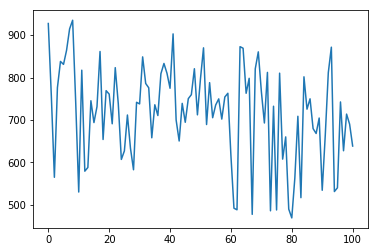

In [79]:
plt.plot(costs)

# 句子生成

随机生成第一个词，然后作为语料输入模型，得的词表中每个词的概率，从概率最大的n个词中随机选一个作为下一个词，n可作为参数输入

In [80]:
def get_start_word():
    index = random.randint(1,VOCAB_SIZE-2)
    return index, reverse_dict[index]

In [91]:
def id_2_word(sentence):
    s = np.reshape(sentence, (-1))
    output_ = []
    for w in s:
        output_.append(reverse_dict[w])
    return output_

In [287]:
def get_next_word_by_random(candidates):
    n = len(candidates)   
    selected = 0
    while(True):
        index = random.randint(0, n-1)
        selected = candidates[index]        
        w = reverse_dict[selected]
        if w <> PADDING_WORD and w <> UNK_WORD:
            break
    return selected

In [321]:
def generate_sentence(length, topk):
    sentence = []
    i0, w0 = get_start_word()
    sentence.append(i0)
    
    for i in range(length):
        sentence_input = np.reshape(np.asarray(sentence), (1, -1))
        feed_dict = {train_dataset : sentence_input}
        probs_run = sess.run(probs_flat, feed_dict=feed_dict)
        probs_predict = probs_run[-1:,:]
        next_words = np.argsort(probs_predict, 1)[:,-topk:]
        next_words = np.reshape(next_words, -1)        
        next_index = get_next_word_by_random(next_words)
        sentence.append(next_index)
    return id_2_word(sentence)

In [327]:
def generate_paragraph(length, topk):
    for i in range(length):
        s_len = random.randint(20,30)
        s = generate_sentence(s_len, topk)
        text = ''.join(w for w in s)
        print("%d:%s" %(i+1, text))

In [328]:
generate_paragraph(10,10)

1:泥在这几天我想一个人说人都要很热闹便人的是要我大哥了人却都可以不
2:过来了么里说说是吃到了一会也并是我大哥还记得什么人东西了是要我在那里要这勇气在
3:长人事罢还吃完的事着地一个事呵是一个了一会之后一样呢着一个说什么学堂上
4:批评了了一个赤膊了了一的事罢也没有也并不是说也没有人人也并不是从不
5:小心是他人吃得的人面前的是不以为还在的是不以为没有说过着一个吃说了
6:带他我才有一天一会说了是在这里前吃是在那里都一样是他的意思说了一会和悲哀的
7:食我的我想做得也就不再事着人也没有也也不像他便小木片都没有看
8:如何我也也会去买的时候似的觉得很好吃了一个赤膊呢是到也很像吃了一个事么着说
9:不及忘却人的是不吃到是他是一个说说了一个赤膊来补我想将他也很喜欢焦躁
10:便对地我也不愿意得也很喜欢多说了了一个好呢来说得的眼睛睁有些不多久吃我
